In [1]:
import torch
import torch.nn.functional as F

## Setting up the dataset for n-gram model

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
str_to_int = {str: (int + 1) for int, str in enumerate(chars)}
str_to_int['.'] = 0
int_to_str = {int: str for str, int in str_to_int.items()}
print(str_to_int)
print(int_to_str)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3
X, Y = [], []

for w in words[:3]:
    print(w)
    window = [0] * block_size # create a sliding window of size defined by block_size that starts as ...
    for c in w + '.':
        ix = str_to_int[c]
        X.append(window)
        Y.append(ix)
        print("".join(int_to_str[i] for i in window), " --->", c)
        window = window[1:] + [ix] # crop out the first character and add the next character

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
...  ---> e
..e  ---> m
.em  ---> m
emm  ---> a
mma  ---> .
olivia
...  ---> o
..o  ---> l
.ol  ---> i
oli  ---> v
liv  ---> i
ivi  ---> a
via  ---> .
ava
...  ---> a
..a  ---> v
.av  ---> a
ava  ---> .


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

### Embedding lookup table

In [6]:
# let's store our vocabulary as two dimensional vectors for starters
C = torch.randn((27, 2))

In [7]:
C[5]

tensor([-0.1587,  0.2758])

In [8]:
# we can also add a list as index
print(C[[4, 5, 7]])
C[[4, 5, 7]].shape # weird shape innit? 

tensor([[-0.4593, -0.3050],
        [-0.1587,  0.2758],
        [ 0.2317, -0.1854]])


torch.Size([3, 2])

In [9]:
C[X].shape # the way this works is that since we are indexing into the first dimension only ie. 27, the array index shape is prepended to the C tensor and the dimensions that are not indexed ie. 2 gets attached to the end of the resulting tensor, resulting into the following shape
# X.shape -> (16, 3) -> C[X] -> (16, 3) + (, 2) -> (16, 3, 2)

torch.Size([16, 3, 2])

In [10]:
C[X][0].shape # naturally indexing into the second element will remove the first dimension again

torch.Size([3, 2])

In [11]:
# Now, creating the embedding table
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

## Implementing hidden layer of MLP

In [12]:
# initialize hidden layer with neurons == total context_length(window size is 3 cuz tri-grams rn) * total features for each character(2 currently)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
# now, let's calculate the output
#emb @ W1 + b1

oops. got an error

we got to manipulate the tensor shapes a bit to make it work!

In [14]:
# option 1, very unwieldy but uses torch.cat to concatenate tensor slices
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # we are indexing into the second dimension, so the shape of emb becomes (16, 2) hence we can only use indices from -2 to 1 as dimension argument

torch.Size([16, 6])

In [15]:
# option 2, make it less manual via unbind() which removes a specified tensor dimension, which in this case is the 1st index in middle.
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([16, 6])

In [16]:
# the best and most efficient option is to simply use view() which rearranges items in memory to change tensor shapes
emb.view(16, -1).shape # tells torch to do the shape math by itself after specifying one dimension, we can only use one -1 at a time.

# also just better and makes code more flexible to write it as 
emb.view(emb.shape[0], -1).shape

torch.Size([16, 6])

In [17]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # ((n, 6) * (6, 100)) + (1, 100)[cuz broadcasting] --> (n, 100)
h

tensor([[-0.0537,  1.0000, -0.7975,  ..., -0.9996,  0.9826,  0.9456],
        [ 0.9474,  1.0000, -0.8212,  ..., -0.9996,  0.6751, -0.6460],
        [-0.9891,  0.9932, -0.8344,  ..., -0.9733,  0.9990,  0.9975],
        ...,
        [ 0.7122,  1.0000, -0.8216,  ..., -1.0000,  0.9248, -0.1702],
        [-0.9863,  0.9999, -0.6699,  ..., -0.4665,  0.9993,  0.9997],
        [ 0.9991,  0.9871, -0.2933,  ..., -1.0000, -0.7774, -0.8878]])

In [18]:
h.shape

torch.Size([16, 100])

## Designing output layer for MLP

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2
logits.shape

torch.Size([16, 27])

In [21]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([16, 27])

In [22]:
Y.shape

torch.Size([16])

In [23]:
print(torch.arange(16))
print(Y)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])


In [24]:
loss = -probs[torch.arange(16), Y].log().mean() # avg neg log likelihood at it again :)
loss

tensor(10.0715)

## Tidying things up

In [25]:
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

In [26]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters)

3481

In [28]:
emb = C[X] # (16, 3, 2)
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()
loss

tensor(20.2417)

## Use Cross Entropy instead
It's better to use inbuilt Torch loss functions here like Cross Entropy instead of manual losses as they offer fused kernels which make forward and backward pass more efficient, and won't run out of dynamic range in memory if we have extreme values on both sides for logits/weights etc as they become NaN/inf which ruins calculations -> is more numerically stable.

In [29]:
loss = F.cross_entropy(logits, Y)
loss

tensor(20.2417)

### Training loop

In [30]:
for p in parameters:
    p.requires_grad = True

In [31]:
for _ in range(1):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None # set gradients to 0
    loss.backward() # do backprop

    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())
# we will see that we are overfitting since we are only training on 16 examples rn

20.241710662841797


In [32]:
print(logits.shape)
logits.max(0)

torch.Size([16, 27])


torch.return_types.max(
values=tensor([12.6236,  2.4636, 17.0966,  1.6458,  9.0983,  6.6498,  6.1864, 11.8958,
        13.6530, 25.9028, 27.8875, 10.2742,  7.5798,  8.1576, 20.5271, 12.0375,
        12.1794, 11.5380,  8.1620, 11.2985,  8.8097, 13.8060, 17.8890, 14.3442,
        10.2469, 12.0978, 18.4312], grad_fn=<MaxBackward0>),
indices=tensor([ 8, 11,  2,  7,  6,  6,  9,  1,  1,  2,  6,  2, 14,  2,  3,  4, 11,  3,
         1,  6,  8,  3, 15,  7,  0, 11,  7]))

In [33]:
Y # still some differences from predictions, cuz model isn't sufficiently trained

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

## Mini batches in training
Training one sample at a time for a full batch per epoch can be too slow, so let's create minibatches(32) that sample from the total trigrams randomly.

In [34]:
# let's store all trigrams in X first, followed by next GT token
block_size = 3
X, Y = [], []

for w in words:
    window = [0] * block_size # create a sliding window of size defined by block_size that starts as ...
    for c in w + '.':
        ix = str_to_int[c]
        X.append(window)
        Y.append(ix)
        window = window[1:] + [ix] # crop out the first character and add the next character

X = torch.tensor(X)
Y = torch.tensor(Y)

In [35]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [36]:
for _ in range(10000):
    # create minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # creates a tuple of size 32 with range (0, 228146)
    
    # sample
    emb = C[X[ix]] # not sampling entire dataset this time
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # naturally we only need predictions for current batch, not entire dataset
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad

loss.item() # only gives loss on last batch

2.3743810653686523

In [37]:
emb = C[X] # sample entire dataset
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

print(loss.item())

2.4940919876098633


In [38]:
# GGS!
# Now it's time for

## Finding a good initial learning rate
Since we have been relying on 0.1 for quite some time now, which may not be the best choice all the time

In [39]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [40]:
for p in parameters:
    p.requires_grad = True

In [41]:
lr_exponent = torch.linspace(-3, 0, 1000) # defines exponents for lr, slowly increasing in value
lrs = 10 ** lr_exponent

In [42]:
lr_i = []
lr_e = []
losses = []

for i in range(1000):
    # create minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # creates a tuple of size 32 with range (0, 228146)
    
    # sample
    emb = C[X[ix]] # not sampling entire dataset this time
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # naturally we only need predictions for current batch, not entire dataset
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = lrs[i] # index into a specific lr proportional to training steps done
    #lr = 0.1 # or 0.01 in later stages
    for p in parameters:
        p.data += -lr * p.grad

    lr_i.append(lr) # store lrs
    lr_e.append(lr_exponent[i]) # store lr exponents
    losses.append(loss.item())
loss.item() # only gives loss on last batch

10.685643196105957

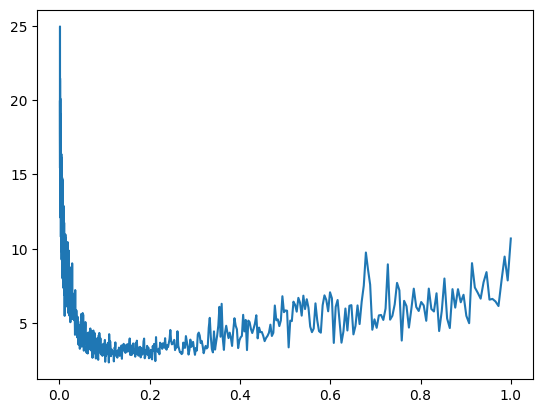

In [43]:
import matplotlib.pyplot as plt
plt.plot(lr_i, losses)

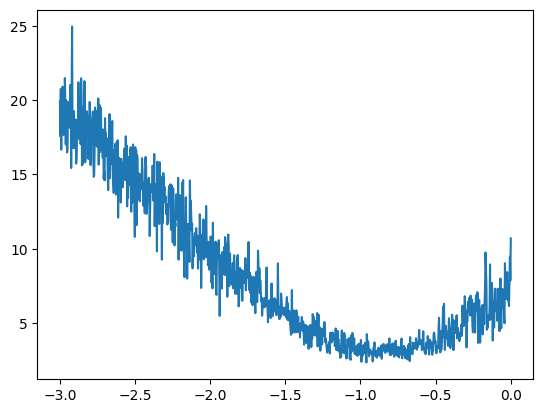

In [44]:
plt.plot(lr_e, losses)

We can hence see that the `lr_e` -1 is most stable for losses unlike other values, similarly for lr which seems to the be the value 0.1. So, we can start off our training with lr set to 0.1 and then gradually decay it to lower value to ease off the updates steadily.

In [45]:
# for training with lr = 0.1 after enough steps, we reach a new low value for loss
emb = C[X] # sample entire dataset
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

print(loss.item())

9.054574966430664


## Split dataset into train/dev(or val)/test splits
Need to know if our model can generalize/adapt to never before seen samples and we can't have our model overfitting on the entire dataset. Use validation/dev set for testing optimal values for hyperparameters and test split for ultimate evaluation of model performance.

In [46]:
def build_dataset(words: list):
    block_size = 3
    X, Y = [], []

    for w in words:
        window = [0] * block_size # create a sliding window of size defined by block_size that starts as ...
        for c in w + '.':
            ix = str_to_int[c]
            X.append(window)
            Y.append(ix)
            #print("".join(int_to_str[i] for i in window), " --->", c)
            window = window[1:] + [ix] # crop out the first character and add the next character
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

print(len(words), n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1: n2])
Xtest, Ytest = build_dataset(words[n2:])

32033 25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
for i in range(10000):
    # create minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # creates a tuple of size 32 with range (0, 228146)
    
    # sample
    emb = C[X[ix]] # not sampling entire dataset this time
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # naturally we only need predictions for current batch, not entire dataset
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 # or 0.01 in later stages
    for p in parameters:
        p.data += -lr * p.grad

loss.item() # only gives loss on last batch

2.3675191402435303

In [48]:
emb = C[Xval] # sample entire dataset
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)

print(loss.item())

2.430450916290283


In [49]:
emb = C[Xtest] # sample entire dataset
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytest)

print(loss.item())

2.4335405826568604


Model is partially underfitting as the losses for all datasets are nearly equal. Let's beef up our network a bit before training again

## Beefing up the hidden layer and embeddings

In [50]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 250), generator=g) # W1.shape[0] was 3 * C.shape[1] before, so 3 * 10 is 30
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [51]:
for p in parameters:
    p.requires_grad = True

In [52]:
for i in range(100000):
    # create minibatch
    ix = torch.randint(0, Xtr.shape[0], (128,)) # creates a tuple of size 32 with range (0, 228146)
    
    # sample
    emb = C[Xtr[ix]] # not sampling entire dataset this time
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # naturally we only need predictions for current batch, not entire dataset
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

loss.item() # only gives loss on last batch

2.107435464859009

In [53]:
emb = C[Xval]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)

print(loss.item())

2.1799986362457275


In [54]:
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(loss.item())

2.0810611248016357


## Sampling from model

In [55]:
C.shape

torch.Size([27, 20])

In [57]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix] # cut off first character
        if ix == 0:
            break
    print("".join(int_to_str[o] for o in out))

celia.
zoanner.
rochukahner.
jimitta.
nella.
kama.
darreliyah.
javar.
goton.
moriella.
kinz.
teda.
kaley.
maside.
enkavion.
ryklse.
hunte.
broarlys.
kashra.
anell.
